<a href="https://colab.research.google.com/github/Ahmadtito17/Machine_Learning/blob/main/Jobsheet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama   : Ahmad Tito NH

NIM    : 2141720265

Kelas  : TI-3G

_________________________________________

**Jobsheet 10 - Recurrent Neural Network (RNN)**

_________________________________________

**Praktikum 1<br>**
RNN untuk Analisis Sentimen

In [ ]:
# Setup
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
# Setup input pipeline
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I read nothing but good things about this movie and finally had a chance to watch it late last night and it was everything I expected it to be and more.This is the way a proper horror movie should be.I think the reason it was so scary was because it was so realistic. The spooky sounding score was perfect for setting a dark mood.I liked the dramatic opening scene and enjoyed how the rest of the movie played out.It was very easy to follow and understand unlike some movies which are way too complicated.The special effects were very good.I would love to see more horror movies like this one.This is easily one of my favorite's.A realistic thunder and lightning storm would have set a nice atmosphere for this movie.Other then that it had all the elements a good horror movie needs.I highly recommend this movie to anyone who can appreciate a good scary movie that pulls no punches.I will be adding it to my collection.The DVD has some interesting special features."
 b"<br /><br />Get yo

In [ ]:
# Buat teks encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 321, 158, ...,   0,   0,   0],
       [ 13,  13,  76, ...,   0,   0,   0],
       [ 83, 775,   6, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I read nothing but good things about this movie and finally had a chance to watch it late last night and it was everything I expected it to be and more.This is the way a proper horror movie should be.I think the reason it was so scary was because it was so realistic. The spooky sounding score was perfect for setting a dark mood.I liked the dramatic opening scene and enjoyed how the rest of the movie played out.It was very easy to follow and understand unlike some movies which are way too complicated.The special effects were very good.I would love to see more horror movies like this one.This is easily one of my favorite's.A realistic thunder and lightning storm would have set a nice atmosphere for this movie.Other then that it had all the elements a good horror movie needs.I highly recommend this movie to anyone who can appreciate a good scary movie that pulls no punches.I will be adding it to my collection.The DVD has some interesting special features."
Round-trip:  i read

In [ ]:
# Buat model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00271291]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 368ms/step
[-0.00271291]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 749s 2s/step - loss: 0.6492 - accuracy: 0.5537 - val_loss: 0.4866 - val_accuracy: 0.7599
Epoch 2/10
391/391 [==============================] - 684s 2s/step - loss: 0.4023 - accuracy: 0.8190 - val_loss: 0.3695 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 694s 2s/step - loss: 0.3412 - accuracy: 0.8521 - val_loss: 0.3442 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 702s 2s/step - loss: 0.3231 - accuracy: 0.8596 - val_loss: 0.3354 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 707s 2s/step - loss: 0.3139 - accuracy: 0.8654 - val_loss: 0.3301 - val_accuracy: 0.8484
Epoch 6/10
391/391 [==============================] - 703s 2s/step - loss: 0.3105 - accuracy: 0.8653 - val_loss: 0.3228 - val_accuracy: 0.8510
Epoch 7/10
391/391 [==============================] - 691s 2s/step - loss: 0.3030 - accuracy: 0.8696 - val_loss: 0.3240 - val_accuracy: 0.8620

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: ', test_loss)
print('Test Accuracy : ', test_acc)

391/391 [==============================] - 165s 423ms/step - loss: 0.3172 - accuracy: 0.8627
Test Loss:  0.31720274686813354
Test Accuracy :  0.8627200126647949


(0.0, 0.6667037352919578)

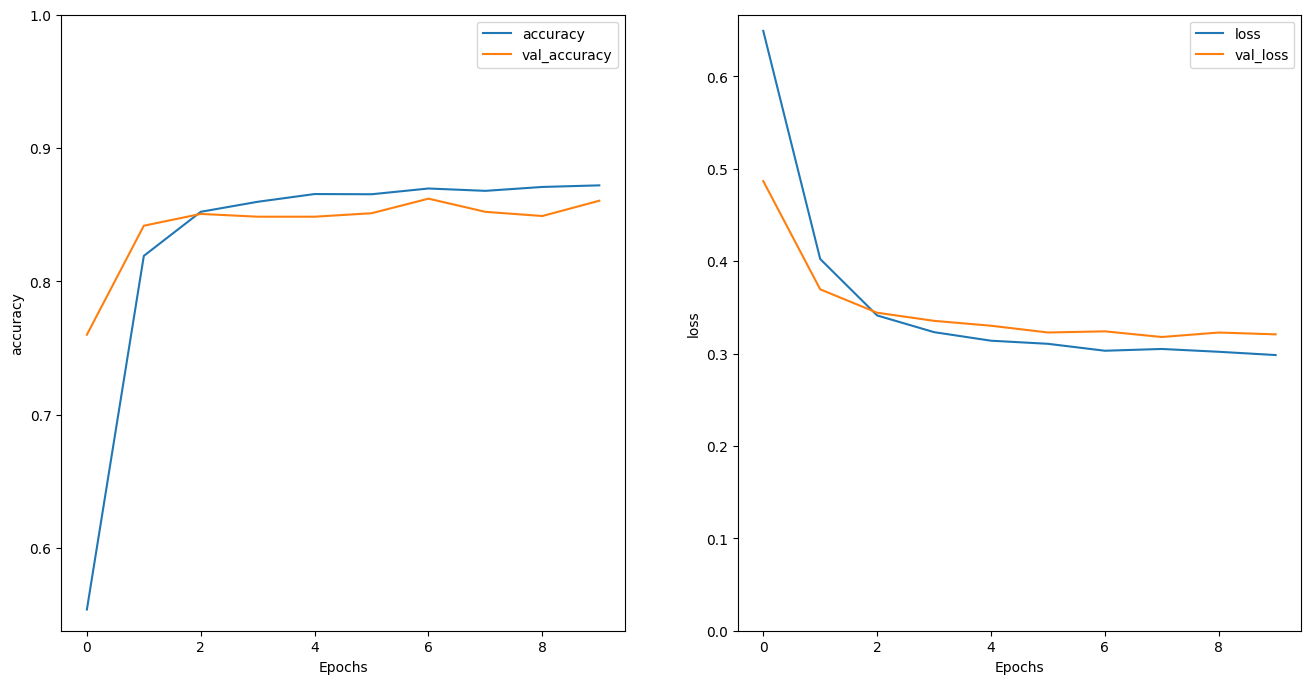

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics'
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [ ]:
# Stack two or more LSTM layers
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1467s 4s/step - loss: 0.6229 - accuracy: 0.5912 - val_loss: 0.4079 - val_accuracy: 0.8297
Epoch 2/10
391/391 [==============================] - 1406s 4s/step - loss: 0.3805 - accuracy: 0.8332 - val_loss: 0.3467 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 1409s 4s/step - loss: 0.3379 - accuracy: 0.8560 - val_loss: 0.3312 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 1422s 4s/step - loss: 0.3221 - accuracy: 0.8625 - val_loss: 0.3288 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 1426s 4s/step - loss: 0.3118 - accuracy: 0.8690 - val_loss: 0.3253 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 1410s 4s/step - loss: 0.3080 - accuracy: 0.8692 - val_loss: 0.3242 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 1356s 3s/step - loss: 0.3052 - accuracy: 0.8700 - val_loss: 0.3210 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 303s 775ms/step - loss: 0.3179 - accuracy: 0.8628
Test Loss: 0.3178909718990326
Test Accuracy: 0.8628000020980835


In [ ]:
# predict on a sample text without padding

sample_text = ('The movie was not good. The animation and the graphics'
                'were terrible. I would not recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 10s 10s/step
[[-1.6083773]]


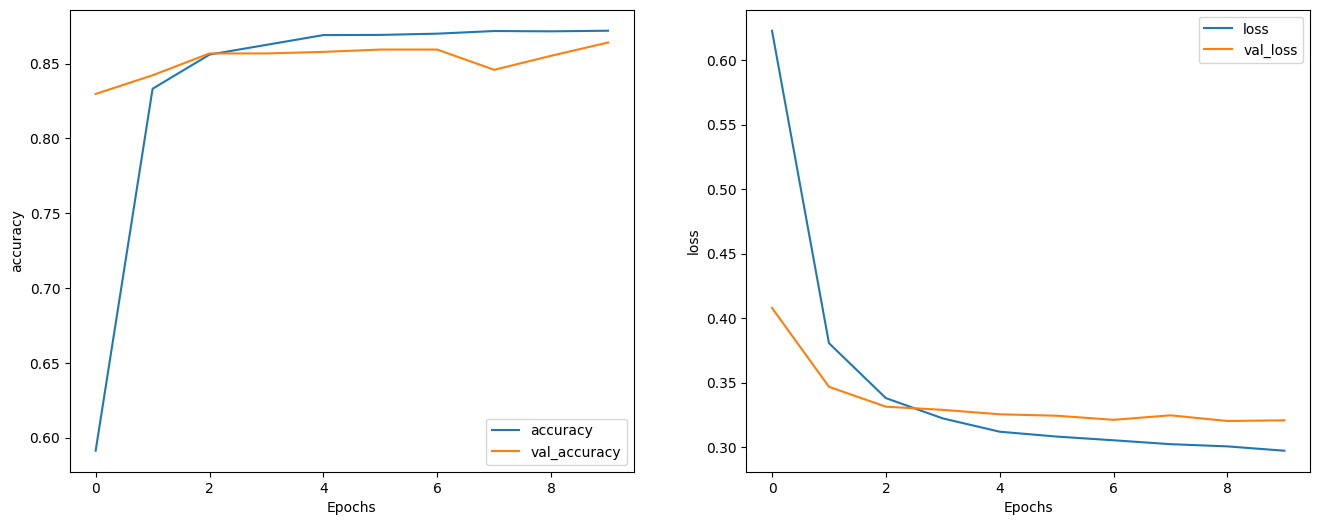

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

**Praktikum 2<br>**
Generator Teks dengan RNN

In [ ]:
# Import tensorflow
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
# Download dataset shakespeare
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
# Load data
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks<br>**
Vectorize Teks

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary = list(vocab), mask_token=None
)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

In [ ]:
# Membuat training set dan target
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [ ]:
# Membuat batch training
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Buat Model**

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices =  tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([51, 56, 18,  2, 56, 20,  6, 12, 20,  1, 18, 13,  7, 46, 48, 53, 22,
       57, 32, 45, 27,  9, 26, 49, 60, 49, 11, 45, 10, 33, 29, 54, 30,  4,
       25, 13,  3,  4, 19, 51, 12, 10, 13, 44, 21, 35, 64, 25,  5, 58,  6,
       18,  7, 15, 63, 36, 18, 16, 50, 10, 30, 48, 33, 16, 53, 10, 21,  4,
       46, 63, 38, 28, 52, 11, 50, 19, 58, 54, 49, 20, 24, 41,  6, 14, 20,
       17,  7, 56, 49, 19,  6, 26,  3, 14,  1, 16,  7, 17,  5, 26])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ELO:\nI show it most of all when I show justice;\nFor then I pity those I do not know,\nWhich a dismiss'

Next Char Predictions:
 b"lqE qG';G\nE?,ginIrSfN.Mjuj:f3TPoQ$L?!$Fl;3?eHVyL&s'E,BxWECk3QiTCn3H$gxYOm:kFsojGKb'AGD,qjF'M!A\nC,D&M"


**Train Model**

In [ ]:
# Tambahan optimizer dan fungsi loss
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1887536, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.94055

In [ ]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoint**

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Lakukan Proses Training**

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 1024s 6s/step - loss: 2.7272
Epoch 2/20
172/172 [==============================] - 1018s 6s/step - loss: 1.9918
Epoch 3/20
172/172 [==============================] - 1007s 6s/step - loss: 1.7115
Epoch 4/20
172/172 [==============================] - 998s 6s/step - loss: 1.5498
Epoch 5/20
172/172 [==============================] - 1000s 6s/step - loss: 1.4498
Epoch 6/20
172/172 [==============================] - 1015s 6s/step - loss: 1.3832
Epoch 7/20
172/172 [==============================] - 1010s 6s/step - loss: 1.3306
Epoch 8/20
172/172 [==============================] - 1047s 6s/step - loss: 1.2858
Epoch 9/20
172/172 [==============================] - 1005s 6s/step - loss: 1.2449
Epoch 10/20
172/172 [==============================] - 1017s 6s/step - loss: 1.2058
Epoch 11/20
172/172 [==============================] - 1018s 6s/step - loss: 1.1666
Epoch 12/20
172/172 [==============================] - 1017s 6s/step - loss: 1.1264
Ep

**Generate Teks**

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
I call'd flowery.

Shepherd:
He hath fought for thee
I charged thee here; I tell thee, noble woman,
Then ask it mest upon; one that it sounded,
Disuppilition, since atcend his tamours.

MENENIUS:
Neither a well; my lord?

Provost:
Art, to the complete of our wretch.
I tell you, 'tis no such a good fellow,
All faith o' younge that I should not be smother'd.
Be patient, taking on, this lawful heart:
Thou enough thy hands of heavy curbshing then to find Servingman:
Wart you now,--O III:
Well, you are gone another; and know thou shalt
Thy raising things for sleep will never conference,
Or I lived to lie into an earth
Our stronger too, and go, here he to die.

CATUS:
Come, come, now, this is a faint yet: gull your manners,
that are put of best baben thou wast.

PETRUCHIO:
A sign, away, indeed; a strangle that
He would prove from Bianca,
The heavens have their petition, think
Hastiness instantly; and to be a punish'd
Knowing how thou hast once fell pasting as bestow'd
Some, as the asp

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nIf love were all commonce on; we are\nForbid your native renowned with Protea:'\n\nSICINIUS:\nSatisfy you, great sir!\nO, pardon me here will I return:\nI thank you, good morrow: 'twere neither spiders' herse,\nAs he falls for fear.\n\nSEBASTIAN:\nHe was with her ignorant to be as madrant.\n\nSecond Gentleman:\nI thank the welcome; that I may yet but beg proclaim us\nAntingled of Rome are enemies?\n\nPRINCE:\nMyself myself dislike, that, as the fay were five\nThat out of poor groats only mine arm\nAnd self against a husband fearful eye.\nRepaintle to Edward and peniteners?\nHave you remember'd, and thy policy's counted\nLest them would have fill'd with rusin's wedding gentle,\nLike stripes repried, and Romeop-inster\nEsseech you by your persing,\nHave at thee to bedow, our pilgrims.\n\nLADY ANNE:\nNo, my lord: while if you be your king?\nYou should not flowers the slave that means to acter.\n\nKING RICHARD II:\nAnd still the window of the creature,\nBut Herch we h

**Ekspor Model Generator**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Some like himself with a lightness to decky: deal: and that
news behold itself and groans or wilt,



**Tugas Praktikum**

In [ ]:
class CustomTraining(MyModel):
 @tf.function
 def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
        predictions = self(inputs, training=True)
        loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 1010s 6s/step - loss: 2.7349


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
      logs = model.train_step([inp, target])
      mean.update_state(logs['loss'])

      if batch_n % 50 == 0:
         template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
         print(template)

 # saving (checkpoint) the model every 5 epochs
      if (epoch + 1) % 5 == 0:
         model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.2122
Epoch 1 Batch 50 Loss 2.0274
Epoch 1 Batch 100 Loss 1.9568
Epoch 1 Batch 150 Loss 1.8465

Epoch 1 Loss: 2.0009
Time taken for 1 epoch 960.19 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8914
Epoch 2 Batch 50 Loss 1.8126
Epoch 2 Batch 100 Loss 1.6607
Epoch 2 Batch 150 Loss 1.6854

Epoch 2 Loss: 1.7280
Time taken for 1 epoch 981.92 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5963
Epoch 3 Batch 50 Loss 1.5709
Epoch 3 Batch 100 Loss 1.5615
Epoch 3 Batch 150 Loss 1.5314

Epoch 3 Loss: 1.5640
Time taken for 1 epoch 981.92 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4865
Epoch 4 Batch 50 Loss 1.4342
Epoch 4 Batch 100 Loss 1.4690
Epoch 4 Batch 150 Loss 1.4348

Epoch 4 Loss: 1.4645
Time taken for 1 epoch 981.92 sec
_________________________________________________________________